# KAIST AI605 Assignment 5: Language Modelling

## Rubric

### Deadline 
The deadline for this assignment is: Friday 2nd December 2022 (Week 14) 11:59pm

### Submission
Please submit your assignment via [KLMS](https://klms.kaist.ac.kr). You must submit both (1) a PDF of your solutions and (2) the Jupyter Notebook file (.ipynb).

Use in-line LaTeX for mathematical expressions. 

### Collaboration
This assignment is not a group assignment so make sure your answer and code are your own. 

### Grading
The total number of marks avaiable is 30 points.

### Environment
This assignment will mostly use the transformers library from huggingface.

The use of a GPU will be beneficial for this assignment.

If you do not have a GPU on your laptop, it is acceptable to use [Google Colab (free)](https://colab.research.google.com) or the departmental subscription of [VESSL](https://vessl.ai), 
**please contact me ASAP to be added if you are from a different department**.


The required environment for this is Python 3.9. Run the following cell to set up the environment.

In [1]:
# !pip install numpy torch tqdm transformers matplotlib

# Problem 0 - Load The Data 
The data for Problems 1, 2 and 3 can be downloaded from KLMS. Each line in the file is an instance is a JSON dictioanary of a Wikipedia. For this assignment only the **text** field is required.

* Reserve 10% of the pages for validation data
* Use any other portion of the data for training

`{"title": "the title of the Wikipedia page",  "text":"the text in the Wikipedia page"}`

In [102]:
# pip install datasets

In [103]:
import json
import torch
from torch import nn
import json
from nltk import word_tokenize
from collections import defaultdict, Counter
import torch.nn.functional as F
import numpy as np
import math
from datasets import *
from transformers import *
from tokenizers import *
import os
from tqdm import tqdm

In [4]:
def load_instances(filename):
    with open(filename) as f:
        for line in f:
            inst = json.loads(line)
            text = inst['text']
            yield word_tokenize(text)
all_inst = list(load_instances("C:/Users/User/Desktop/NLP/ass5/wiki.jsonl"))      
# print(all_inst[0])
n = len(all_inst)
print(f'All data: {n}')
train_instances, dev_instances = all_inst[:int(n*0.9)], all_inst[int(n*0.9):]
print(f'Train lenght: {len(train_instances)}')
print(f'Test lenght: {len(dev_instances)}')

All data: 2914
Train lenght: 2622
Test lenght: 292


# Problem 1 - Features of Language (6 points)

## Problem 1.1 (4 points) - Zipfs Law

Zipfs law (introduced in Lecture 1) indicates a reverse exponential relationship between the frequency of a token $w$, $f_w$, and its rank of frequency $r_w$ (where rank is the position with respect to frequency in comparison to other words).

$$
f_w \approx \frac{k}{r_w^\alpha}
$$


* Find the frequencies of all unique tokens in the dataset and rank them

* Plot the frequency vs rank graph for the highest 10,000 ranked tokens with a log-log scale

* Plot a line of best fit and estimate the values of $k$ and $\alpha$ 


In [4]:
vocab_counter = Counter()
for text in all_inst:
    vocab_counter.update(text)
vocab_counter = dict(sorted(vocab_counter.items(), key=lambda item: item[1], reverse = True))
vocab_counter = {i + 1: (token, frequency) for i, (token, frequency) in enumerate(vocab_counter.items())}
# most_common = {math.log(i): math.log(items[1]) for i, items in vocab_counter.items() if items[1]>=10000}
most_common = {i: items[1] for j, (i, items) in enumerate(vocab_counter.items()) if j>=10000}
vocab_counter

{1: ('the', 869431),
 2: (',', 858193),
 3: ('.', 574493),
 4: ('of', 477376),
 5: ('and', 423298),
 6: ('in', 319390),
 7: ('to', 307820),
 8: ('a', 264721),
 9: ('was', 154621),
 10: ('The', 131163),
 11: ("'s", 115968),
 12: ('that', 114943),
 13: ('as', 114408),
 14: (')', 113762),
 15: ('(', 113746),
 16: ('for', 102230),
 17: ('``', 99072),
 18: ('by', 97725),
 19: ('with', 96947),
 20: ('on', 95504),
 21: ('is', 94711),
 22: ("''", 93799),
 23: ('from', 74246),
 24: ('his', 67246),
 25: ('were', 61886),
 26: ('at', 60693),
 27: ('it', 54504),
 28: ('which', 49433),
 29: ('had', 49041),
 30: ('an', 48956),
 31: ('are', 48228),
 32: ('he', 45792),
 33: (';', 43640),
 34: ('be', 41782),
 35: ('In', 40613),
 36: (':', 38625),
 37: ('have', 38461),
 38: ('or', 35965),
 39: ('not', 35631),
 40: ('but', 34690),
 41: ('been', 33255),
 42: ('its', 32761),
 43: ('their', 32222),
 44: ('her', 28214),
 45: ('also', 27907),
 46: ('has', 27283),
 47: ('this', 25112),
 48: ('first', 24762),
 4

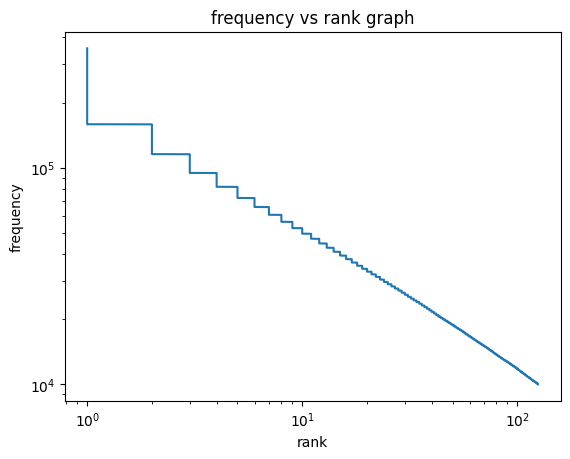

In [5]:
import matplotlib.pyplot as plt
plt.plot(most_common.values(),most_common.keys())
plt.ylabel('frequency')
plt.xlabel('rank')
plt.title("frequency vs rank graph")
plt.xscale('log')
plt.yscale('log')
plt.show()

In [6]:
# normalized frequency 
alpha = 0.1
k = 3.65
y = k / (np.array([*most_common.values()])**alpha)

In [41]:
#find line of best fit
x = np.array([*most_common.values()])
y = np.array([*most_common.keys()])
a, b, c = np.polyfit(1/y, x, 2)

In [47]:
y_pred = a*x**2 + b*x + c
y_pred

array([1.62038332e+10, 1.62038332e+10, 1.62038332e+10, ...,
       1.03707837e+06, 1.03707837e+06, 1.03707837e+06])

In [51]:
from scipy.optimize import curve_fit

def f(x, A, B): 
    return A/(x**B)

popt, pcov = curve_fit(f, x, y) # your data x, y to fit

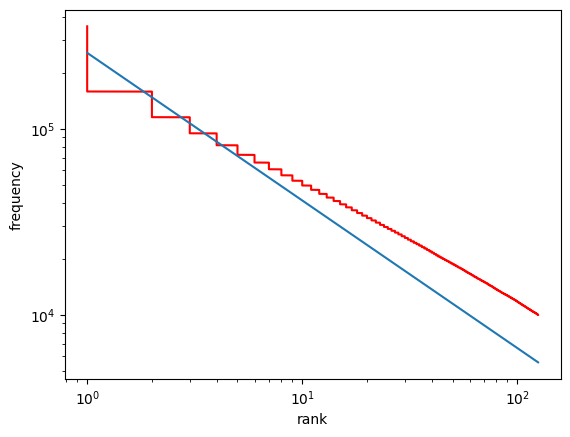

In [52]:
plt.plot(x,y, color = 'red')
plt.plot(x, f(x, *popt))
plt.ylabel('frequency')
plt.xlabel('rank')
plt.xscale('log')
plt.yscale('log')
plt.show()

## Problem 1.2 (2 points) - Contextual Embeddings

[Deep contextualized word representations (Peters et al., 2018)](https://arxiv.org/pdf/1802.05365.pdf) uses an LSTM-based architecture to generate meaning representations of tokens. 

Using the linked paper as reference, highlight the differences between using static word embeddings and contextual representations and suggest two reasons how the language-modelling objective helps other NLP tasks.

Static word emmbeddings are using finite large number of vocab words to emmbed the meaning of each token.

The LSTM-based architecture (to be exact the one intrduce in paper biLM is trying to capture deeper sense of the word (like part of speech). It's using the subwords units and character convolutions. The model is learning the linear combination of the vectors stacked above each input word for each end task. 

As mentioned in the article previous approaches allowed a single context independent representation for each word. 

# Problem 2 - BERT-style Language Models (14 points)

## Problem 2.1 (8 points) - BERT Language Model
Using the provided data, train a language model with the [BERT]((https://aclanthology.org/N19-1423.pdf) masked language model objective (NSP prediction task is not reuqired). Select appropriate model size and hyperparameters. 

* Make the training data yourself

* Print a sample of training instances (both the model inputs and expected outputs)

* Plot the loss regularly (e.g. after an epoch or fixed number of training steps) on a graph. Report the loss for both the training data and validation data.

* Use the `transformers` library implementation of a suitable tokenizer and model for language modelling with BERT. But do not use a pre-trained language model (i.e. start with a randomly initialized model).  

Hint: you can use [BERTConfig](https://huggingface.co/docs/transformers/v4.24.0/en/model_doc/bert#transformers.BertConfig) to configure your language model, and use [BERTForMaskedLM](https://huggingface.co/docs/transformers/v4.24.0/en/model_doc/bert#transformers.BertForMaskedLM) which is a pre-configured language model. 

Hint: You should use the [AdamW optimizer](https://huggingface.co/docs/transformers/v4.24.0/en/main_classes/optimizer_schedules#transformers.AdamW)

In [168]:
import vessl
from vessl.integration.keras import ExperimentCallback

ModuleNotFoundError: No module named 'vessl.integration.pytorch'

In [ ]:
vessl.init()

In [90]:
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

loading configuration file config.json from cache at C:\Users\User/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\User/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\vocab.txt

In [49]:
special_tokens = [
  "[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "<S>", "<T>"
]
# if you want to train the tokenizer on both sets
# files = ["train.txt", "test.txt"]
# training the tokenizer on the training set
files = ["C:/Users/User/Desktop/NLP/ass5/wiki.jsonl"]
model_path = "pretrained-bert"

# 30,522 vocab is BERT's default vocab size, feel free to tweak
vocab_size = 30_522
# maximum sequence length, lowering will result to faster training (when increasing batch size)
max_length = 512
# whether to truncate
truncate_longer_samples = False

In [143]:
dataset = load_dataset('json', data_files=files, split="train")

Using custom data configuration default-8ad91c1a24ac6a16


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to C:/Users/User/.cache/huggingface/datasets/json/default-8ad91c1a24ac6a16/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


In [146]:
dataset['text'][0]

'7 World Trade Center (7 WTC, WTC-7, or Tower 7) refers to two buildings that have existed at the same location within the World Trade Center site in Lower Manhattan, New York City. The original structure, part of the original World Trade Center, was completed in 1987 and was destroyed in the September 11 attacks in 2001. The current structure opened in May 2006. Both buildings were developed by Larry Silverstein, who holds a ground lease for the site from the Port Authority of New York and New Jersey.\nThe original 7 World Trade Center was 47 stories tall, clad in red granite masonry, and occupied a trapezoidal footprint. An elevated walkway spanning Vesey Street connected the building to the World Trade Center plaza. The building was situated above a Consolidated Edison power substation, which imposed unique structural design constraints. When the building opened in 1987, Silverstein had difficulties attracting tenants. Salomon Brothers signed a long-term lease in 1988 and became the

In [141]:
# def preprocess_function(examples):

#     text_arrays = [x.split('\\n') for x in examples['text']]
#     for 

#     return inputs

# dataset = dataset.map(preprocess_function, batched=True)

In [147]:
# split the dataset into training (90%) and testing (10%)
d = dataset.train_test_split(test_size=0.1)
d["train"], d["test"]

(Dataset({
     features: ['title', 'text'],
     num_rows: 2622
 }),
 Dataset({
     features: ['title', 'text'],
     num_rows: 292
 }))

In [153]:
def encode_with_truncation(examples):
    """Mapping function to tokenize the sentences passed with truncation"""
    return bert_tokenizer(examples["text"], truncation=True, padding="max_length",
                   max_length=max_length, return_special_tokens_mask=True)

def encode_without_truncation(examples):
    """Mapping function to tokenize the sentences passed without truncation"""
    return bert_tokenizer(examples["text"], return_special_tokens_mask=True)

# the encode function will depend on the truncate_longer_samples variable
encode = encode_with_truncation if truncate_longer_samples else encode_without_truncation
# tokenizing the train dataset
train_dataset = d["train"].map(encode, batched=True)
# tokenizing the testing dataset
test_dataset = d["test"].map(encode, batched=True)
if truncate_longer_samples:
    # remove other columns and set input_ids and attention_mask as PyTorch tensors
    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
    test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
else:
    # remove other columns, and remain them as Python lists
    test_dataset.set_format(columns=["input_ids", "attention_mask", "special_tokens_mask"])
    train_dataset.set_format(columns=["input_ids", "attention_mask", "special_tokens_mask"])

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [152]:
# def group_texts(examples):
#     tokenized_inputs = bert_tokenizer(examples["text"], return_special_tokens_mask=True, 
#                                       padding="max_length",truncation=True, max_length=max_length,
#                                       return_special_tokens_mask=True)
#     return tokenized_inputs

# # preprocess dataset
# tokenized_datasets = d["train"].map(group_texts, batched=True, remove_columns=["text"], num_proc=1)
# tokenized_datasets.features

SyntaxError: keyword argument repeated: return_special_tokens_mask (2725515266.py, line 2)

In [157]:
test_dataset

Dataset({
    features: ['title', 'text', 'input_ids', 'token_type_ids', 'attention_mask', 'special_tokens_mask'],
    num_rows: 292
})

In [158]:
from itertools import chain
# Main data processing function that will concatenate all texts from our dataset and generate chunks of
# max_seq_length.
# grabbed from: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= max_length:
        total_length = (total_length // max_length) * max_length
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + max_length] for i in range(0, total_length, max_length)]
        for k, t in concatenated_examples.items()
    }
    return result

# Note that with `batched=True`, this map processes 1,000 texts together, so group_texts throws away a
# remainder for each of those groups of 1,000 texts. You can adjust that batch_size here but a higher value
# might be slower to preprocess.
#
# To speed up this part, we use multiprocessing. See the documentation of the map method for more information:
# https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map
if not truncate_longer_samples:
    train_dataset = train_dataset.map(group_texts, batched=True,
                                    desc=f"Grouping texts in chunks of {max_length}")
    test_dataset = test_dataset.map(group_texts, batched=True,
                                  desc=f"Grouping texts in chunks of {max_length}")
    # convert them from lists to torch tensors
    train_dataset.set_format("torch")
    test_dataset.set_format("torch")

Grouping texts in chunks of 512:   0%|          | 0/3 [00:00<?, ?ba/s]

Grouping texts in chunks of 512:   0%|          | 0/1 [00:00<?, ?ba/s]

In [159]:
len(train_dataset), len(test_dataset)

(32109, 3703)

In [95]:
# all_tokenized = bert_tokenizer(

#     all_inst,

#     padding=True,

#     truncation=True,

#     max_length=512,

#     return_tensors="pt",

# )

In [76]:
# # split the dataset into training (90%) and testing (10%)
# split_num = int(0.9*len(all_tokenized['input_ids']))
# d = {}
# d["train"] = all_tokenized[:split_num]
# d["test"] = all_tokenized[split_num:]

In [160]:
# initialize the model with the config
model_config = BertConfig(vocab_size=vocab_size, max_position_embeddings=max_length)
model = BertForMaskedLM(config=model_config)

In [161]:
# initialize the data collator, randomly masking 20% (default is 15%) of the tokens for the Masked Language
# Modeling (MLM) task
data_collator = DataCollatorForLanguageModeling(
    tokenizer=bert_tokenizer, mlm=True, mlm_probability=0.2
)

In [162]:
training_args = TrainingArguments(
    output_dir=model_path,          # output directory to where save model checkpoint
    evaluation_strategy="steps",    # evaluate each `logging_steps` steps
    overwrite_output_dir=True,      
    num_train_epochs=10,            # number of training epochs, feel free to tweak
    per_device_train_batch_size=10, # the training batch size, put it as high as your GPU memory fits
    gradient_accumulation_steps=8,  # accumulating the gradients before updating the weights
    per_device_eval_batch_size=64,  # evaluation batch size
    logging_steps=1000,             # evaluate, log and save model checkpoints every 1000 step
    save_steps=1000,
    # load_best_model_at_end=True,  # whether to load the best model (in terms of loss) at the end of training
    # save_total_limit=3,           # whether you don't have much space so you let only 3 model weights saved in the disk
)

using `logging_steps` to initialize `eval_steps` to 1000
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [165]:
# initialize the trainer and pass everything to it
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [166]:
# train the model
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: special_tokens_mask. If special_tokens_mask are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 32109
  Num Epochs = 10
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 80
  Gradient Accumulation steps = 8
  Total optimization steps = 4010
  Number of trainable parameters = 109514298
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# load the model checkpoint
model = BertForMaskedLM.from_pretrained(os.path.join(model_path, "checkpoint-10000"))
# load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_path)

In [169]:
# # split the dataset into training (90%) and testing (10%)
# d = dataset.train_test_split(test_size=0.1)
# d["train"], d["test"]

In [170]:
# for t in d["train"]["text"][:3]:
#   print(t)
#   print("="*50)

In [25]:
# # initialize the WordPiece tokenizer
# tokenizer = BertWordPieceTokenizer()
# # train the tokenizer
# tokenizer.train(files=files, vocab_size=vocab_size, special_tokens=special_tokens)
# # enable truncation up to the maximum 512 tokens
# tokenizer.enable_truncation(max_length=max_length)

In [28]:
# model_path = "pretrained-bert"
# # make the directory if not already there
# if not os.path.isdir(model_path):
#     os.mkdir(model_path)
# # save the tokenizer  
# tokenizer.save_model(model_path)
# # dumping some of the tokenizer config to config file, 
# # including special tokens, whether to lower case and the maximum sequence length
# with open(os.path.join(model_path, "config.json"), "w") as f:
#     tokenizer_cfg = {
#       "do_lower_case": True,
#       "unk_token": "[UNK]",
#       "sep_token": "[SEP]",
#       "pad_token": "[PAD]",
#       "cls_token": "[CLS]",
#       "mask_token": "[MASK]",
#       "model_max_length": max_length,
#       "max_len": max_length,
#     }
#     json.dump(tokenizer_cfg, f)

In [29]:
# # when the tokenizer is trained and configured, load it as BertTokenizerFast
# tokenizer = BertTokenizerFast.from_pretrained(model_path)

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file pretrained-bert\config.json
Model config BertConfig {
  "_name_or_path": "pretrained-bert",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "cls_token": "[CLS]",
  "do_lower_case": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_token": "[MASK]",
  "max_len": 512,
  "max_position_embeddings": 512,
  "model_max_length": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token": "[PAD]",
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "sep_token": "[SEP]",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "unk_token": "[UNK]",
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration f

In [ ]:
# def encode_with_truncation(examples):
#     """Mapping function to tokenize the sentences passed with truncation"""
#     return tokenizer(examples["text"], truncation=True, padding="max_length",
#                    max_length=max_length, return_special_tokens_mask=True)

# def encode_without_truncation(examples):
#     """Mapping function to tokenize the sentences passed without truncation"""
#     return tokenizer(examples["text"], return_special_tokens_mask=True)

# # the encode function will depend on the truncate_longer_samples variable
# encode = encode_with_truncation if truncate_longer_samples else encode_without_truncation
# # tokenizing the train dataset
# train_dataset = d["train"].map(encode, batched=True)
# # tokenizing the testing dataset
# test_dataset = d["test"].map(encode, batched=True)
# if truncate_longer_samples:
#     # remove other columns and set input_ids and attention_mask as PyTorch tensors
#     train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
#     test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
# else:
#     # remove other columns, and remain them as Python lists
#     test_dataset.set_format(columns=["input_ids", "attention_mask", "special_tokens_mask"])
#     train_dataset.set_format(columns=["input_ids", "attention_mask", "special_tokens_mask"])

  0%|          | 0/638 [00:00<?, ?ba/s]

In [ ]:
# #from the run_mlm.py script from the huggingface transformers examples

# from itertools import chain
# # Main data processing function that will concatenate all texts from our dataset and generate chunks of
# # max_seq_length.
# # grabbed from: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
# def group_texts(examples):
#     # Concatenate all texts.
#     concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
#     total_length = len(concatenated_examples[list(examples.keys())[0]])
#     # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
#     # customize this part to your needs.
#     if total_length >= max_length:
#         total_length = (total_length // max_length) * max_length
#     # Split by chunks of max_len.
#     result = {
#         k: [t[i : i + max_length] for i in range(0, total_length, max_length)]
#         for k, t in concatenated_examples.items()
#     }
#     return result

# # Note that with `batched=True`, this map processes 1,000 texts together, so group_texts throws away a
# # remainder for each of those groups of 1,000 texts. You can adjust that batch_size here but a higher value
# # might be slower to preprocess.
# #
# # To speed up this part, we use multiprocessing. See the documentation of the map method for more information:
# # https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map
# if not truncate_longer_samples:
#     train_dataset = train_dataset.map(group_texts, batched=True,
#                                     desc=f"Grouping texts in chunks of {max_length}")
#     test_dataset = test_dataset.map(group_texts, batched=True,
#                                   desc=f"Grouping texts in chunks of {max_length}")
#     # convert them from lists to torch tensors
#     train_dataset.set_format("torch")
#     test_dataset.set_format("torch")

In [ ]:
# len(train_dataset), len(test_dataset)

## Problem 2.2 (2 points) - Hyperparameters
Experiment with changing model 3-4 of the model hyperparameters (e.g. sequence length, number of attention heads, hidden dimension, number of layers, etc). How do these change the training behaviour and loss of your model and why?

## Problem 2.3 (4 points) - BERT vs RoBERTa 
Identifiy the key similarities and differences between the BERT and RoBERTa language models and discuss how these contribute to RoBERTa being a stronger language model

* [BERT](https://aclanthology.org/N19-1423.pdf)
* [RoBERTa](https://arxiv.org/abs/1907.11692) 

The preapering for masking is different between those two models. In BERT model masking is performed only once during the data preparation and RoBERTa is masking during the training proce. We can have multiple verions of masking sentence since it's not prepared before. That's why RoBERTa is more robust, it's not bounted by the static masks like BERT. 

# Problem 3 - Sequence-to-sequence-language models (10 points) 

## Problem 3.1 (4 points) - seq2seq LM training objective
Compare the pre-training objectives listed in the [BART](https://aclanthology.org/2020.acl-main.703.pdf) paper and give examples of model inputs and outputs. With these pre-training objectives, compare their effects on downstream NLP tasks. 

Note: coding is not required for this question

## Problem 3.2 (6 points) - Infilling Language Model
Using the provided data, train a language model with the [BART](https://aclanthology.org/2020.acl-main.703.pdf) **text infilling** objective (other types of pre-training objectives are not reuqired). Select appropriate model size and hyperparameters. 

* Make the training data yourself

* Print a sample of training instances (both the model inputs and expected outputs)

* Plot the loss regularly (e.g. after an epoch or fixed number of training steps). Report the loss for both the training data and validation data

* Use the `transformers` library implementation of a suitable tokenizer and model for language modelling with BART. But do not use a pre-trained language model (i.e. start with a randomly initialized model).  

* It is only required to show convergence of your model for a few epochs

Hint: you can sample sequence lengths from the Poisson distribution using the random library in [Numpy](https://numpy.org/doc/stable/reference/random/generated/numpy.random.poisson.html).  